<a href="https://colab.research.google.com/github/Sallemi7Dorsaf/COVID-19/blob/master/Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade -q pygsheets

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import google.auth
from google.colab import auth
auth.authenticate_user()
import pygsheets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
credentials, _ = google.auth.default()
gc = pygsheets.client.Client(credentials)

In [0]:
def plotbar(datList,labelList,title):
  posList = range(len(datList))
  plt.figure(figsize=(16, 6))
  plt.bar(posList,datList)
  plt.title(title)
  plt.xticks(posList, labelList,rotation='vertical')
  plt.grid()
  plt.show()

In [0]:
sheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Ojyifha6IqBKb1SIvst-4pEyJbAXFUJee6iHmxS9B1I/edit?usp=sharing')
dat = sheet.sheet1.get_as_df()
dat = dat[['summary','country','death','symptom']]
odat = dat.copy()
odat['age'] = dat['summary'].str.extract(r'( \d+,)')
odat['age'] = odat['age'].str.extract(r'(\d+)').astype('float')
odat['gender'] = dat['summary'].str.extract(r'(male|female)')
odat['death'] = odat['death'] == 1
odat = odat.dropna()

# 1. Age analysis

In [0]:
odat['agegroup'] = 'agegroup'
ageDic = {}
ageDic['1-10'] = (1,10)
ageDic['10-20'] = (10,20)
ageDic['20-30'] = (20,30)
ageDic['30-40'] = (30,40)
ageDic['40-50'] = (40,50)
ageDic['50-60'] = (50,60)
ageDic['60-70'] = (60,70)
ageDic['70+'] = (70,120)
for k in ageDic.keys():
  lb,ub = ageDic[k]
  odat['agegroup'][(odat['age']>=lb) & (odat['age']<ub)] = k
odat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,summary,country,death,symptom,age,gender,agegroup
0,First confirmed imported COVID-19 pneumonia pa...,China,False,,66.0,male,60-70
1,First confirmed imported COVID-19 pneumonia pa...,China,False,,56.0,female,50-60
2,First confirmed imported cases in Zhejiang: pa...,China,False,,46.0,male,40-50
3,new confirmed imported COVID-19 pneumonia in T...,China,False,,60.0,female,60-70
4,new confirmed imported COVID-19 pneumonia in T...,China,False,,58.0,male,50-60
...,...,...,...,...,...,...,...
3387,new COVID-19 patient confirmed in Switzerland:...,Switzerland,False,,70.0,male,70+
3392,new COVID-19 patient confirmed in Switzerland:...,Switzerland,False,,26.0,male,20-30
3393,new COVID-19 patient confirmed in Switzerland:...,Switzerland,False,,30.0,female,30-40
3394,new COVID-19 patient confirmed in Switzerland:...,Switzerland,False,,49.0,male,40-50


In [0]:
agestat = odat.groupby('agegroup').count()[['age']]
agestat['ageratio'] = agestat['age']/sum(agestat['age'])*100
agestat


,age,ageratio
agegroup,,
1-10,12,1.664355
10-20,26,3.606103
20-30,92,12.760055
30-40,127,17.614424
40-50,114,15.811373
50-60,148,20.527046
60-70,107,14.840499
70+,95,13.176144


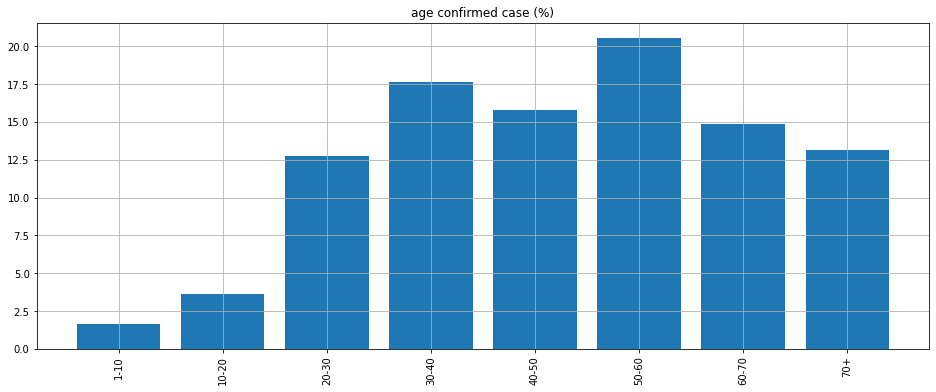

In [0]:
plotbar(agestat['ageratio'].values,agestat.index.values,'age confirmed case (%)')

In [0]:
drDic = {}
for k in ageDic.keys():
  adat = odat[odat['agegroup']==k]
  drDic[k] = (sum(adat['death']),len(adat['death']),sum(adat['death'])/len(adat['death'])*100)
#drDic.values()
drFrame = pd.DataFrame(data=drDic.values(),columns=['death-count','confirmed-count','death-ratio'])
drFrame.index = drDic.keys()
drFrame

,death-count,confirmed-count,death-ratio
1-10,0,12,0.000000
10-20,0,26,0.000000
20-30,0,92,0.000000
30-40,2,127,1.574803
40-50,1,114,0.877193
50-60,4,148,2.702703
60-70,12,107,11.214953
70+,22,95,23.157895


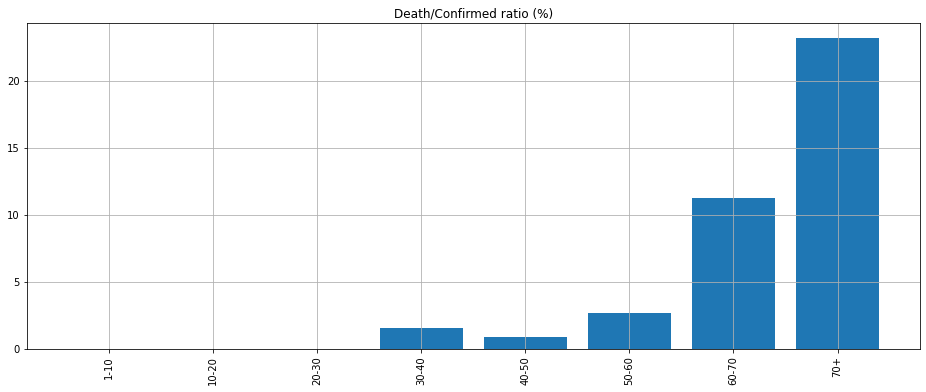

In [0]:
plotbar(drFrame['death-ratio'],list(drFrame.index),'Death/Confirmed ratio (%)')

# 2. Gender analysis

In [0]:
gdat = odat[['death','gender']]
gc = gdat.groupby(by='gender').count()
gd = gdat.groupby(by='gender').sum()
gender_dratio = gd['death']/gc['death']
gender_dratio

gender
female    0.039088
male      0.070048
Name: death, dtype: float64

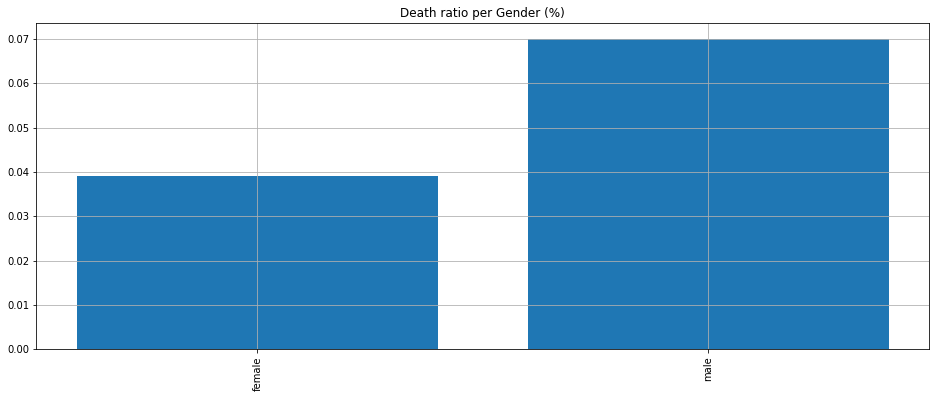

In [0]:
plotbar(gender_dratio,gender_dratio.index,'Death ratio per Gender (%)')

# 3. Symptom

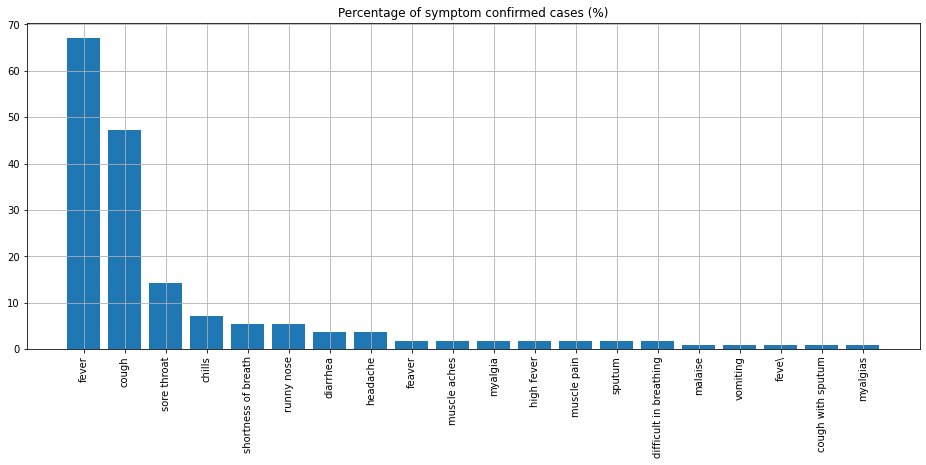

In [0]:
symptomList = odat[odat['symptom'].str.len()>2]
symptomList = symptomList['symptom'].values
symDic = {}
for s in symptomList:
  sList = s.split(',')
  for st in sList:
    st = st.strip()
    try:
      symDic[st] = symDic[st] + 1
    except:
      symDic[st] = 1
symFrame = pd.DataFrame()
symFrame['symptom'] = symDic.keys()
symFrame['count'] = symDic.values()
symFrame = symFrame.sort_values(by='count',ascending=False)
symFrame = symFrame.iloc[0:20]
symFrame['ncount'] = (symFrame['count']/len(symptomList))*100
plotbar(symFrame['ncount'],symFrame['symptom'],'Percentage of symptom confirmed cases (%)')